# Cognitive Science Project

In [ ]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content


In [ ]:
!unzip hymenoptera_data.zip

unzip:  cannot find or open hymenoptera_data.zip, hymenoptera_data.zip.zip or hymenoptera_data.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

In [ ]:
data_dir = '/content/drive/My Drive/hymenoptera_data'
BATCH_SIZE = 8
NUM_WORKERS = 2

# Training parameters
NUM_EPOCHS = 15

# Initial set up for data loading

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dictionary of train and val datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

# dict of dataloaders, dataset sizes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FileNotFoundError: ignored

In [ ]:
print("Device being use: ", device)

NameError: ignored

In [ ]:
# inputs, classes = next(iter(dataloaders['train']))

In [ ]:
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)
# print("BLURRED INPUTS...")
# imshow(out, title=[class_names[x] for x in classes])

BLURRED INPUTS...


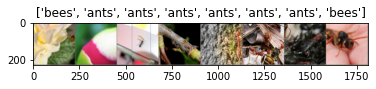

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

print("BLURRED INPUTS...") # Adding temporarily for gaussian blur, we might need to experiement by adding a noise function as well - gaussian blur is a smoothing function so it isn't really achieving the addition of noise to the image.
imshow(out, title=[class_names[x] for x in classes])

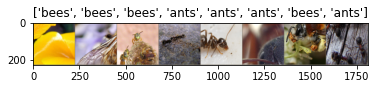

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train the model and return the model with weights that lead to best val accuracy during training
    
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features # Get the number of incoming features to the last layer and change that to 2 before fine-tuning
model_ft.classifier[6].out_features = len(class_names) # len(class_names) = 2 for our dataset
model_ft = model_ft.to(device)
print("Final model...", model_ft)


criterion = nn.CrossEntropyLoss()

# Train all parameters. Maybe we could change this as a way to study degradation?
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Final model... AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=40

In [ ]:
trained_base_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: 2.9039 Acc: 0.4549
val Loss: 1.4497 Acc: 0.5294

Epoch 1/14
----------
train Loss: 1.0110 Acc: 0.5820
val Loss: 0.8174 Acc: 0.6209

Epoch 2/14
----------
train Loss: 0.7090 Acc: 0.6352
val Loss: 1.4863 Acc: 0.5033

Epoch 3/14
----------
train Loss: 0.9471 Acc: 0.5943
val Loss: 1.3359 Acc: 0.5425

Epoch 4/14
----------
train Loss: 0.7630 Acc: 0.5902
val Loss: 0.6086 Acc: 0.6797

Epoch 5/14
----------
train Loss: 0.5873 Acc: 0.7049
val Loss: 0.5577 Acc: 0.7386

Epoch 6/14
----------
train Loss: 0.5081 Acc: 0.7377
val Loss: 0.5788 Acc: 0.7843

Epoch 7/14
----------
train Loss: 0.4212 Acc: 0.7828
val Loss: 0.5220 Acc: 0.7582

Epoch 8/14
----------
train Loss: 0.4013 Acc: 0.8074
val Loss: 0.5186 Acc: 0.7320

Epoch 9/14
----------
train Loss: 0.3697 Acc: 0.8238
val Loss: 0.5190 Acc: 0.7516

Epoch 10/14
----------
train Loss: 0.3594 Acc: 0.8607
val Loss: 0.5097 Acc: 0.7843

Epoch 11/14
----------
train Loss: 0.3304 Acc: 0.8566
val Loss: 0.5049 Acc: 0.7778

Ep

In [ ]:
# torch.save(trained_base_model, os.path.join(data_dir, 'trained_base_model'))
torch.save(trained_base_model.state_dict(), os.path.join(data_dir, 'trained_base_state_dict')) # Better method is to save and load state dict

In [ ]:
from google.colab import files

In [ ]:
files.download(os.path.join(data_dir, 'trained_base_state_dict'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Baseline model used: AlexNet finetuned on hymenoptera (with required changes to final linear layer)

### Baseline train accuracy = 84.02%
### Baseline (best) Validation accuracy = 79.73%

In [ ]:
# With blur

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features # Get the number of incoming features to the last layer and change that to 2 before fine-tuning
model_ft.classifier[6].out_features = len(class_names) # len(class_names) = 2 for our dataset
model_ft = model_ft.to(device)
print("Final model used for experiment with blur...", model_ft)


criterion = nn.CrossEntropyLoss()

# Train all parameters. Maybe we could change this as a way to study degradation?
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Final model used for experiment with blur... AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_f

In [ ]:
trained_blur_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: 2.5360 Acc: 0.4713
val Loss: 0.9292 Acc: 0.4771

Epoch 1/14
----------
train Loss: 0.8913 Acc: 0.5697
val Loss: 1.2774 Acc: 0.4771

Epoch 2/14
----------
train Loss: 0.8610 Acc: 0.5697
val Loss: 0.6798 Acc: 0.6405

Epoch 3/14
----------
train Loss: 0.5842 Acc: 0.7295
val Loss: 0.7887 Acc: 0.6732

Epoch 4/14
----------
train Loss: 0.6079 Acc: 0.7172
val Loss: 0.5837 Acc: 0.6797

Epoch 5/14
----------
train Loss: 0.5824 Acc: 0.7008
val Loss: 0.5962 Acc: 0.7059

Epoch 6/14
----------
train Loss: 0.4917 Acc: 0.7787
val Loss: 0.5355 Acc: 0.7712

Epoch 7/14
----------
train Loss: 0.4220 Acc: 0.8402
val Loss: 0.5123 Acc: 0.7647

Epoch 8/14
----------
train Loss: 0.3892 Acc: 0.8197
val Loss: 0.5306 Acc: 0.7451

Epoch 9/14
----------
train Loss: 0.3837 Acc: 0.8197
val Loss: 0.5068 Acc: 0.7386

Epoch 10/14
----------
train Loss: 0.3862 Acc: 0.8320
val Loss: 0.5286 Acc: 0.7059

Epoch 11/14
----------
train Loss: 0.3721 Acc: 0.8156
val Loss: 0.5324 Acc: 0.7647

Ep

# With just gaussian blur: AlexNet finetuned on hymenoptera (with required changes to final linear layer)

### Train accuracy = 86.02% 
### Best Validation accuracy = 77.12% (slight drop from baseline accuracy of 79%)

## Adding Gaussian Noise to the input as a simulation of poor sensory perception

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
data_dir = '/content/drive/My Drive/hymenoptera_data'
BATCH_SIZE = 1
NUM_WORKERS = 2

# Training parameters
NUM_EPOCHS = 15

# Initial set up for data loading

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0.5, 1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0.5, 1)
    ]),
}

# dictionary of train and val datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

# dict of dataloaders, dataset sizes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Sample inputs with Custom Gaussian Noise added - Simulating poor sensory perception


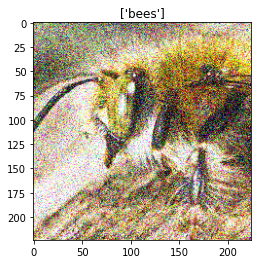

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

print("Sample inputs with Custom Gaussian Noise added - Simulating poor sensory perception")
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# With added gaussian noise

model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features # Get the number of incoming features to the last layer and change that to 2 before fine-tuning
model_ft.classifier[6].out_features = len(class_names) # len(class_names) = 2 for our dataset
model_ft = model_ft.to(device)
print("Final model used for experiment with added gaussian noise...", model_ft)


criterion = nn.CrossEntropyLoss()

# Train all parameters. Maybe we could change this as a way to study degradation?
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Final model used for experiment with added gaussian noise... AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    

In [ ]:
# Training model that learns on noisy images
trained_noise_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: nan Acc: 0.4918
val Loss: nan Acc: 0.4575

Epoch 1/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 2/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 3/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 4/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 5/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 6/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 7/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 8/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 9/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 10/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 11/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.4575

Epoch 12/14
----------
train Loss: nan Acc: 0.5041
val Loss: nan Acc: 0.45

In [ ]:
torch.save(trained_noise_model.state_dict(), os.path.join(data_dir, 'trained_noise_state_dict')) # Better method is to save and load state dict

# Simulation of loss in sensory perception:

When we simulate loss in visual sensory perception by adding noise to the input images (we are viewing the input layer of the network as sort of the "eye" equivalent here), we see a marked difference in performance with the same amount of training. As expected the performance degrades in comparison to our baseline. 

Yet, the performance is not close to 0 and is in fact more close to the optimal performance than it is to 0. This is one indicator of how degradation isn't necessarily drastic in this scenario.

## Training accuracy = 50.41%
## Best validation accuracy = 45.75%

## Pruning the network

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/CogSci

/content/drive/MyDrive/CogSci


In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import copy

import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F


In [ ]:
data_dir = '/content/drive/My Drive/CogSci/hymenoptera_data'
BATCH_SIZE = 8
NUM_WORKERS = 2

# Training parameters
NUM_EPOCHS = 15

# Initial set up for data loading

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.GaussianBlur(7, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dictionary of train and val datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

# dict of dataloaders, dataset sizes
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Device being use: ", device)

Device being use:  cuda:0


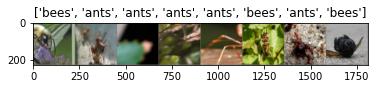

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Train the model and return the model with weights that lead to best val accuracy during training
    
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features # Get the number of incoming features to the last layer and change that to fine-tune
model_ft.classifier[6].out_features = len(class_names) # len(class_names) = 2 for our dataset
model_ft = model_ft.to(device)
print("Final model...", model_ft)


criterion = nn.CrossEntropyLoss()

# Train all parameters. Maybe we could change this as a way to study degradation?
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Final model... AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=40

Baseline Model

In [ ]:
trained_base_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: 1.6662 Acc: 0.5287
val Loss: 1.8235 Acc: 0.5163

Epoch 1/14
----------
train Loss: 1.6687 Acc: 0.5205
val Loss: 1.8305 Acc: 0.5556

Epoch 2/14
----------
train Loss: 1.7018 Acc: 0.5205
val Loss: 1.8291 Acc: 0.5752

Epoch 3/14
----------
train Loss: 1.6544 Acc: 0.5369
val Loss: 1.8211 Acc: 0.5621

Epoch 4/14
----------
train Loss: 1.6607 Acc: 0.5533
val Loss: 1.8223 Acc: 0.5033

Epoch 5/14
----------
train Loss: 1.7043 Acc: 0.5205
val Loss: 1.8127 Acc: 0.5294

Epoch 6/14
----------
train Loss: 1.8012 Acc: 0.5082
val Loss: 1.8384 Acc: 0.5294

Epoch 7/14
----------
train Loss: 1.7419 Acc: 0.5041
val Loss: 1.8130 Acc: 0.5294

Epoch 8/14
----------
train Loss: 1.6427 Acc: 0.5328
val Loss: 1.7967 Acc: 0.5621

Epoch 9/14
----------
train Loss: 1.6883 Acc: 0.5287
val Loss: 1.8154 Acc: 0.5229

Epoch 10/14
----------
train Loss: 1.6839 Acc: 0.5287
val Loss: 1.8110 Acc: 0.5033

Epoch 11/14
----------
train Loss: 1.7034 Acc: 0.4918
val Loss: 1.8450 Acc: 0.4967

Ep

## Training Accuracy: 0.8893
## Best Validation Accuracy: 0.7973

In [ ]:
from collections.abc import Iterable

def get_prunable_modules(model):
  modules = nn.Sequential(*list(trained_base_model.children()))

  # parameters_to_prune = []

  # for m in modules:
  #   if isinstance(m, Iterable):
  #     for c in m:
  #       if 'weight' in c.named_parameters():
  #         parameters_to_prune.append((c, 'weight'))
  #   else:
  #     if 'weight' in c.named_parameters():
  #       parameters_to_prune.append((m, 'weight'))

  # for m in modules:
  #   if isinstance(m, Iterable):
  #     for c in m:
  #       if isinstance(c, torch.nn.Conv2d) or isinstance(c, torch.nn.Linear):
  #         parameters_to_prune.append((m, 'weight'))

  # print(modules)
  parameters_to_prune = (
      (modules[0][0], 'weight'),
      (modules[0][3], 'weight'),
      (modules[0][6], 'weight'),
      (modules[0][8], 'weight'),
      (modules[0][10], 'weight'),

      (modules[2][1], 'weight'),
      (modules[2][4], 'weight'),
      (modules[2][6], 'weight')
  )

  modules_pruned = (
      (modules[0][0]),
      (modules[0][3]),
      (modules[0][6]),
      (modules[0][8]),
      (modules[0][10]),

      (modules[2][1]),
      (modules[2][4]),
      (modules[2][6])
      )

  return parameters_to_prune, modules_pruned

Prune weights randomly (Unstructured)

In [ ]:
def do_pruning(pruned_model, value = 0.35):

  parameters_to_prune, modules_to_prune = get_prunable_modules(trained_base_model)
  print(parameters_to_prune)

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=value,
  )

  for m in modules_to_prune:
    prune.remove(m, 'weight')

  return pruned_model

In [ ]:
prune_percentage = 0.45
pruned_model = trained_base_model

pruned_model = do_pruning(pruned_model, prune_percentage)

((Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)), 'weight'), (Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), 'weight'), (Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'weight'), (Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'weight'), (Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 'weight'), (Linear(in_features=9216, out_features=4096, bias=True), 'weight'), (Linear(in_features=4096, out_features=4096, bias=True), 'weight'), (Linear(in_features=4096, out_features=2, bias=True), 'weight'))


In [ ]:
pruned_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Should we run over test data for all models?

def evaluate(model):

  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0

  # Iterate over data.
  # idx = 0
  for inputs, labels in dataloaders['val']:
      # print(idx)
      # idx += 1
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward
      # track history if only in train
      with torch.set_grad_enabled(False):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

  loss = running_loss / dataset_sizes['val']
  acc = running_corrects.double() / dataset_sizes['val']

  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      'Validation', loss, acc))

In [ ]:
evaluate(pruned_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Validation Loss: 0.4713 Acc: 0.7908


In [ ]:
torch.save(pruned_model.state_dict(), os.path.join(data_dir, 'unstructured_pruned_model'))


## Best Validation Accuracy after 15% pruning: 0.7778

## Best Validation Accuracy after 25% pruning: 0.7908

## Best Validation Accuracy after 35% pruning: 0.7843

## Best Validation Accuracy after 45% pruning: 0.7778


Retrain after pruning

In [ ]:
trained_base_model = train_model(pruned_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: 0.3518 Acc: 0.8730
val Loss: 0.4888 Acc: 0.7712

Epoch 1/14
----------
train Loss: 0.3462 Acc: 0.8607
val Loss: 0.4925 Acc: 0.7516

Epoch 2/14
----------
train Loss: 0.3615 Acc: 0.8320
val Loss: 0.4990 Acc: 0.7451

Epoch 3/14
----------
train Loss: 0.3461 Acc: 0.8443
val Loss: 0.4778 Acc: 0.7778

Epoch 4/14
----------
train Loss: 0.3717 Acc: 0.8402
val Loss: 0.4773 Acc: 0.7647

Epoch 5/14
----------
train Loss: 0.3549 Acc: 0.8648
val Loss: 0.5008 Acc: 0.7582

Epoch 6/14
----------
train Loss: 0.3627 Acc: 0.8320
val Loss: 0.4966 Acc: 0.7386

Epoch 7/14
----------
train Loss: 0.3667 Acc: 0.8402
val Loss: 0.4865 Acc: 0.7712

Epoch 8/14
----------
train Loss: 0.3758 Acc: 0.8443
val Loss: 0.4833 Acc: 0.7778

Epoch 9/14
----------
train Loss: 0.3384 Acc: 0.8648
val Loss: 0.4874 Acc: 0.7712

Epoch 10/14
----------
train Loss: 0.3487 Acc: 0.8689
val Loss: 0.4855 Acc: 0.7778

Epoch 11/14
----------
train Loss: 0.3286 Acc: 0.8893
val Loss: 0.4824 Acc: 0.7712

Ep

## Training Accuracy at 15%: 0.8484
## Best Validation Accuracy at 15%: 0.7974


## Training Accuracy at 25%: 0.8893
## Best Validation Accuracy at 25%: 0.7908

## Training Accuracy at 35%: 0.8402
## Best Validation Accuracy at 35%: 0.8039

## Training Accuracy at 45%: 0.8648
## Best Validation Accuracy at 45%: 0.7778

In [ ]:
torch.save(pruned_model.state_dict(), os.path.join(data_dir, 'unstructured_pruned_model_trained'))

Prune weights (structured)

In [ ]:
def do_structured_pruning(pruned_model, value = 0.35):
  parameters_to_prune, modules_to_prune = get_prunable_modules(trained_base_model)
  for m, name in parameters_to_prune:
    prune.ln_structured(m, name=name, amount=value, n=2, dim=0)

  for m in modules_to_prune:
    prune.remove(m, 'weight')

  return pruned_model

In [ ]:
prune_percentage = 0.15
pruned_model = trained_base_model

pruned_model = do_structured_pruning(pruned_model, prune_percentage)

In [ ]:
evaluate(pruned_model)

Validation Loss: 1.8252 Acc: 0.5033


Retrain after pruning

In [ ]:
trained_pruned_model = train_model(pruned_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/14
----------
train Loss: 1.7089 Acc: 0.5082
val Loss: 1.8686 Acc: 0.4706

Epoch 1/14
----------
train Loss: 1.7495 Acc: 0.4918
val Loss: 1.8478 Acc: 0.5294

Epoch 2/14
----------
train Loss: 1.6950 Acc: 0.5041
val Loss: 1.8215 Acc: 0.5882

Epoch 3/14
----------
train Loss: 1.7311 Acc: 0.5041
val Loss: 1.8270 Acc: 0.5294

Epoch 4/14
----------
train Loss: 1.6679 Acc: 0.5492
val Loss: 1.8056 Acc: 0.5425

Epoch 5/14
----------
train Loss: 1.6446 Acc: 0.5697
val Loss: 1.8274 Acc: 0.5621

Epoch 6/14
----------
train Loss: 1.6865 Acc: 0.5164
val Loss: 1.7943 Acc: 0.5294

Epoch 7/14
----------
train Loss: 1.6803 Acc: 0.5041
val Loss: 1.8172 Acc: 0.5425

Epoch 8/14
----------
train Loss: 1.6610 Acc: 0.5451
val Loss: 1.8369 Acc: 0.5229

Epoch 9/14
----------
train Loss: 1.7235 Acc: 0.5369
val Loss: 1.8392 Acc: 0.5294

Epoch 10/14
----------
train Loss: 1.7083 Acc: 0.5328
val Loss: 1.8152 Acc: 0.5229

Epoch 11/14
----------
train Loss: 1.6955 Acc: 0.5082
val Loss: 1.8149 Acc: 0.5556

Ep

## Validation Accuracy at 15% pruning: 0.5098

## Training Accuracy at 15% pruning after retraining: 0.7705
## Validation Accuracy at 15% pruning after retraining: 0.7778



## Validation Accuracy at 25% pruning: 0.4837
## Training Accuracy at 25% pruning after retraining: 0.5123
## Validation Accuracy at 25% pruning after retraining: 0.4837


--
## Validation Accuracy at 35% pruning: 0.4902
## Training Accuracy at 35% pruning after retraining: 0.5160
## Validation Accuracy at 35% pruning after retraining: 0.5620



## Validation Accuracy at 45% pruning: 0.5621
## Training Accuracy at 45% pruning after retraining: 0.5164
## Validation Accuracy at 45% pruning after retraining: 0.5621



